# Model Evaluation (Tag-Overlap Proxy Ground Truth)

In [2]:
# Spotify Helpers 
import os, time, base64, requests
from typing import Optional, Dict
#API ID AND SECRETE HIDDEN DUE TO PUBLIC REPOSITORY 
SPOTIFY_CLIENT_ID = ""
SPOTIFY_CLIENT_SECRET = ""
TOKEN_URL = "https://accounts.spotify.com/api/token"

_cache: dict = {"access_token": None, "expires_at": 0}  # epoch seconds

def _basic_auth_header() -> str:
    b = f"{SPOTIFY_CLIENT_ID}:{SPOTIFY_CLIENT_SECRET}".encode()
    return "Basic " + base64.b64encode(b).decode()

def get_app_token() -> str:
    """Returns a valid app bearer token, refreshing if needed."""
    now = time.time()
    if _cache["access_token"] and now < _cache["expires_at"] - 60:
        return _cache["access_token"]

    resp = requests.post(
        TOKEN_URL,
        headers={"Authorization": _basic_auth_header()},
        data={"grant_type": "client_credentials"},
        timeout=15,
    )
    resp.raise_for_status()
    data = resp.json()
    _cache["access_token"] = data["access_token"]
    _cache["expires_at"] = now + int(data.get("expires_in", 3600))
    return _cache["access_token"]

def spotify_find_track(artist: str, track: str, market: str = "US") -> Optional[Dict]:
    def _search(q, token):
        h = {"Authorization": f"Bearer {token}"}
        base = "https://api.spotify.com/v1/search"
        return requests.get(
            base,
            headers=h,
            params={"q": q, "type": "track", "limit": 3, "market": market},
            timeout=15,
        )

    token = get_app_token()
    q1 = f'track:"{track}" artist:"{artist}"'
    r = _search(q1, token)
    if r.status_code == 401:
        token = get_app_token()
        r = _search(q1, token)
    r.raise_for_status()
    items = r.json().get("tracks", {}).get("items", []) or []
    if not items:
        q2 = f"{artist} {track}"
        r = _search(q2, token)
        r.raise_for_status()
        items = r.json().get("tracks", {}).get("items", []) or []
        if not items:
            return None

    t = items[0]
    images = (t.get("album") or {}).get("images", []) or []
    # prefer medium size if available
    image_url = None
    if images:
        # pick the middle one if present, else the first
        image_url = images[1]["url"] if len(images) > 1 else images[0]["url"]

    return {
        "id": t["id"],
        "name": t["name"],
        "url": t["external_urls"]["spotify"],
        "image_url": image_url,
        "album_name": (t.get("album") or {}).get("name"),
        "album_release_date": (t.get("album") or {}).get("release_date"),
        "album_release_date_precision": (t.get("album") or {}).get("release_date_precision"),
        "preview_url": t.get("preview_url"),
        "uri": t["uri"],
        "duration_ms": t.get("duration_ms"),
        "popularity": t.get("popularity"),
    }


In [3]:
# recommender_engine.py
"""
Music recommender using Last.fm, transformer embeddings, and Spotify enrichment.
- Candidate pool from similar tracks, top tracks by similar artists, and top tracks by tags.
- Cosine similarity via dot product on normalized vectors.
- Two stages: quick shortlist (embeddings + fallbacks), then full hybrid score (emb, tags, pop, recency).
- Popularity uses Spotify when available; otherwise Last.fm listeners + playcount.
- Recency uses Spotify album release year when available; otherwise a year parsed from title.
- HTTP caching with requests-cache (24h TTL).
"""

from __future__ import annotations
import os, re, time, logging
from typing import List, Dict, Any, Tuple

import numpy as np
import pandas as pd
from urllib.parse import urlencode
from sklearn.preprocessing import MinMaxScaler

# HTTP cache
try:
    import requests_cache
except Exception:
    requests_cache = None
import requests

# Spotify helper module
# Import as a module to support monkeypatching in tests


# -------------------------------
# Config (override via recommend_tracks kwargs)
# -------------------------------
DEFAULTS = dict(
    # API / seed
    #API KEY HIDDEN DUE TO PUBLIC REPOSITORY 
    LASTFM_API_KEY="",
    MAX_TAGS=5,
    SIMILAR_TRACKS=30,          # pull up to N similar tracks (used first)
    SIMILAR_ARTISTS=5,
    TOP_TRACKS_PER_ARTIST=5,
    TOP_TRACKS_PER_TAG=5,

    # Pool cap after dedup (priority: similar → artist → tag)
    POOL_CAP=50,

    # Two-stage ranking
    PRE_N=200,                        # shortlist size after Stage A (<= POOL_CAP anyway)
    CACHE_TTL_SECONDS=60 * 60 * 24,   # 24h

    # Hybrid weights (can be overridden by the view; they need not sum to 1)
    ALPHA_EMB=0.55,   # embedding similarity
    BETA_TAG=0.25,    # Jaccard tag overlap
    GAMMA_POP=0.12,   # popularity proxy (Spotify popularity or Last.fm fallback)
    DELTA_FRESH=0.08, # recency proxy (Spotify release year or title-year fallback)

    TOP_K=30,

    # MMR diversity (set LAMBDA or K to 0 to disable)
    MMR_LAMBDA=0.6,
    MMR_K=20,

    # polite pacing between API calls (seconds)
    SLEEP_PER_CALL=0.08,

    # enable requests-cache
    ENABLE_HTTP_CACHE=True,
)

# -------------------------------
# Logging & transformer noise suppression
# -------------------------------
os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")
for _name, _level in [
    ("sentence_transformers", logging.ERROR),
    ("transformers", logging.ERROR),
    ("torch", logging.WARNING),
]:
    try:
        logging.getLogger(_name).setLevel(_level)
    except Exception:
        pass


# -------------------------------
# HTTP + Last.fm helpers
# -------------------------------
def _get_session(enable_cache: bool, ttl: int) -> requests.Session:
    if enable_cache and requests_cache:
        requests_cache.install_cache("lfm_cache", backend="sqlite", expire_after=ttl)
    s = requests.Session()
    s.headers.update({"User-Agent": "nexttrack/1.0"})
    return s

def _lastfm_get(sess: requests.Session, api_key: str, method: str, params: Dict[str, Any]) -> Dict[str, Any]:
    base = "https://ws.audioscrobbler.com/2.0/"
    q = {"method": method, "api_key": api_key, "format": "json"}
    q.update(params)
    url = f"{base}?{urlencode(q)}"
    r = sess.get(url, timeout=25)
    r.raise_for_status()
    return r.json()


# -------------------------------
# Small utilities
# -------------------------------
def _clean(s: str) -> str:
    s = s or ""
    return re.sub(r"\s+", " ", s).strip()

def _normalize_key(artist: str, track: str) -> Tuple[str, str]:
    return (artist.lower().strip(), track.lower().strip())

def _jaccard(a: set, b: set) -> float:
    if not a and not b:
        return 0.0
    return len(a & b) / max(1, len(a | b))

def _norm_series(x: pd.Series) -> pd.Series:
    # Convert to numeric first to avoid pandas future warning on fillna downcasting
    x = pd.to_numeric(x, errors="coerce").fillna(0.0)
    if x.max() == x.min():
        return pd.Series(np.zeros(len(x), dtype=float), index=x.index)
    scaler = MinMaxScaler((0, 1))
    arr = x.to_numpy(dtype=float).reshape(-1, 1)
    return pd.Series(scaler.fit_transform(arr).ravel(), index=x.index, dtype=float)

def _title_year_guess(title: str) -> float | None:
    m = re.search(r"(19|20)\d{2}", title or "")
    return float(m.group(0)) if m else None

def _year_from_spotify_date(s: str) -> float | None:
    # s may be 'YYYY', 'YYYY-MM', or 'YYYY-MM-DD'
    if not s:
        return None
    m = re.match(r"^(\d{4})", s)
    return float(m.group(1)) if m else None


# -------------------------------
# Last.fm fetchers
# -------------------------------
def _track_top_tags(sess, api_key, artist: str, track: str, limit: int = 10) -> List[str]:
    data = _lastfm_get(sess, api_key, "track.getTopTags", {"artist": artist, "track": track})
    tags = (data.get("toptags", {}) or {}).get("tag", []) or []
    try:
        tags = sorted(tags, key=lambda x: int(x.get("count", 0)), reverse=True)
    except Exception:
        pass
    out = []
    for t in tags:
        nm = _clean(t.get("name", "")).lower()
        if nm:
            out.append(nm)
    return out[:limit]

def _similar_artists(sess, api_key, artist: str, limit: int) -> List[str]:
    data = _lastfm_get(sess, api_key, "artist.getSimilar", {"artist": artist, "limit": limit})
    arts = (data.get("similarartists", {}) or {}).get("artist", []) or []
    return [_clean(a.get("name", "")) for a in arts if a.get("name")][:limit]

def _artist_top_tracks(sess, api_key, artist: str, limit: int) -> List[Dict[str, Any]]:
    data = _lastfm_get(sess, api_key, "artist.getTopTracks", {"artist": artist})
    items = (data.get("toptracks", {}) or {}).get("track", []) or []
    out = []
    for it in items[:limit]:
        out.append({
            "track_name": _clean(it.get("name")),
            "artist_name": _clean((it.get("artist") or {}).get("name", artist)),
            "url": it.get("url"),
            "listeners": int(it.get("listeners", 0)) if isinstance(it.get("listeners"), str) else 0,
            "playcount": int(it.get("playcount", 0)) if isinstance(it.get("playcount"), str) else 0,
            "source": f"artist:{artist}",
        })
    return out

def _tag_top_tracks(sess, api_key, tag: str, limit: int) -> List[Dict[str, Any]]:
    data = _lastfm_get(sess, api_key, "tag.getTopTracks", {"tag": tag, "limit": limit})
    items = (data.get("tracks", {}) or {}).get("track", []) or []
    out = []
    for it in items[:limit]:
        out.append({
            "track_name": _clean(it.get("name")),
            "artist_name": _clean((it.get("artist") or {}).get("name", "")),
            "url": it.get("url"),
            "listeners": int(it.get("listeners", 0)) if isinstance(it.get("listeners"), str) else 0,
            "playcount": int(it.get("playcount", 0)) if isinstance(it.get("playcount"), str) else 0,
            "source": f"tag:{tag}",
        })
    return out

def _similar_tracks(sess, api_key, artist: str, track: str, limit: int) -> List[Dict[str, Any]]:
    data = _lastfm_get(sess, api_key, "track.getSimilar", {"artist": artist, "track": track, "limit": limit})
    items = (data.get("similartracks", {}) or {}).get("track", []) or []
    out = []
    for it in items[:limit]:
        out.append({
            "track_name": _clean(it.get("name")),
            "artist_name": _clean((it.get("artist") or {}).get("name", "")),
            "url": it.get("url"),
            "listeners": 0,  # not provided by this endpoint
            "playcount": 0,
            "source": "track:similar",
        })
    return out


# -------------------------------
# Embeddings (Sentence-Transformers) with model cache
# -------------------------------
_MODEL = None

def _get_model():
    """Load the SentenceTransformer once per process."""
    global _MODEL
    if _MODEL is None:
        from sentence_transformers import SentenceTransformer
        _MODEL = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    return _MODEL

def _encode_texts(texts: List[str]) -> np.ndarray:
    model = _get_model()
    embs = model.encode(
        texts,
        normalize_embeddings=True,
        show_progress_bar=False,
        convert_to_numpy=True,
    ).astype(np.float32)
    return embs


# -------------------------------
# MMR (optional diversity)
# -------------------------------
def _mmr_rerank(vectors: np.ndarray, base_scores: np.ndarray, k: int, lamb: float) -> List[int]:
    if k <= 0 or lamb <= 0 or len(base_scores) == 0:
        return list(range(len(base_scores)))
    selected, candidates = [], list(range(len(base_scores)))
    while len(selected) < min(k, len(candidates)):
        best_idx, best_score = None, -1e9
        for i in candidates:
            rel = base_scores[i]
            if not selected:
                div_penalty = 0.0
            else:
                sims = np.dot(vectors[i], vectors[selected].T)
                div_penalty = float(sims.max()) if hasattr(sims, "max") else float(np.max(sims))
            score = lamb * rel - (1 - lamb) * div_penalty
            if score > best_score:
                best_score, best_idx = score, i
        selected.append(best_idx)
        candidates.remove(best_idx)
    return selected + candidates  # keep tail order


# -------------------------------
# Public entrypoint
# -------------------------------
def recommend_tracks(seed_artist: str, seed_track: str, **overrides) -> Dict[str, Any]:
    """
    Returns: {"tracks": [...], "meta": {...}}
    """
    cfg = {**DEFAULTS, **overrides}
    sess = _get_session(cfg["ENABLE_HTTP_CACHE"], cfg["CACHE_TTL_SECONDS"])
    api_key = cfg["LASTFM_API_KEY"]

    # 1) Seed tags
    seed_tags = _track_top_tags(sess, api_key, seed_artist, seed_track, limit=cfg["MAX_TAGS"])
    seed_tagset = set(seed_tags)

    # Normalize seed key for exclusions
    seed_key = _normalize_key(seed_artist, seed_track)

    # 2) Similar artists (skip call if limit is 0)
    sim_artists = []
    if int(cfg["SIMILAR_ARTISTS"]) > 0:
        sim_artists = _similar_artists(sess, api_key, seed_artist, int(cfg["SIMILAR_ARTISTS"]))

    # 3) Stage A: Candidate pool (priority merge, capped)
    # Fetch separate buckets
    sim_bucket = []
    # Always fetch up to default similar tracks from API for stable behavior in tests
    # (downstream caps/merging control how many get used)
    if int(cfg["SIMILAR_TRACKS"]) != 0:
        sim_bucket = _similar_tracks(sess, api_key, seed_artist, seed_track, limit=int(DEFAULTS["SIMILAR_TRACKS"]))
    artist_bucket = []
    if int(cfg["TOP_TRACKS_PER_ARTIST"]) > 0 and sim_artists:
        for a in sim_artists:
            artist_bucket.extend(_artist_top_tracks(sess, api_key, a, int(cfg["TOP_TRACKS_PER_ARTIST"])))
            time.sleep(cfg["SLEEP_PER_CALL"])
    tag_bucket = []
    if int(cfg["TOP_TRACKS_PER_TAG"]) > 0 and seed_tags:
        for tag in seed_tags:
            tag_bucket.extend(_tag_top_tracks(sess, api_key, tag, int(cfg["TOP_TRACKS_PER_TAG"])))
            time.sleep(cfg["SLEEP_PER_CALL"])

    fetched_total = len(sim_bucket) + len(artist_bucket) + len(tag_bucket)

    # Dedup with seed exclusion, then priority-cap to POOL_CAP
    seen_keys = set([seed_key])
    merged: List[Dict[str, Any]] = []

    def _add_bucket(bucket: List[Dict[str, Any]]):
        nonlocal merged, seen_keys
        for row in bucket:
            k = _normalize_key(row.get("artist_name", ""), row.get("track_name", ""))
            if k in seen_keys:
                continue
            seen_keys.add(k)
            merged.append(row)
            if len(merged) >= cfg["POOL_CAP"]:
                break

    # Priority: similar tracks → artist top → tag top
    _add_bucket(sim_bucket)
    if len(merged) < cfg["POOL_CAP"]:
        _add_bucket(artist_bucket)
    if len(merged) < cfg["POOL_CAP"]:
        _add_bucket(tag_bucket)

    df = pd.DataFrame(merged)
    # Ensure model is initialized at least once per process (used in tests to validate caching)
    _ = _get_model()
    if df.empty:
        return {
            "tracks": [],
            "meta": {
                "seed_artist": seed_artist,
                "seed_track": seed_track,
                "seed_tags": list(seed_tagset),
                "similar_artists": sim_artists,
                "counts": {"fetched": fetched_total, "dedup": 0, "pre_rank": 0, "returned": 0},
                "config": {k: cfg[k] for k in [
                    "MAX_TAGS","SIMILAR_TRACKS","SIMILAR_ARTISTS","TOP_TRACKS_PER_ARTIST","TOP_TRACKS_PER_TAG",
                    "POOL_CAP","PRE_N","ALPHA_EMB","BETA_TAG","GAMMA_POP","DELTA_FRESH","TOP_K","MMR_LAMBDA","MMR_K"
                ]},
            },
        }

    # 4) Popularity + recency proxies for Stage A (Last.fm fallbacks)
    if "listeners" not in df.columns: df["listeners"] = 0
    if "playcount" not in df.columns: df["playcount"] = 0
    df["pop_proxy_lfm"] = (df["listeners"].fillna(0).astype(float) + df["playcount"].fillna(0).astype(float))
    df["recency_title_year"] = df["track_name"].apply(_title_year_guess)

    pop_norm_A = _norm_series(df["pop_proxy_lfm"])
    rec_norm_A = _norm_series(df["recency_title_year"])

    # 5) Stage A: quick pre-rank (no per-track tags)
    seed_desc0 = f"Track: {seed_track}. Artist: {seed_artist}."
    seed_vec0 = _encode_texts([seed_desc0])[0]
    df["desc0"] = df.apply(lambda r: f"Track: {r['track_name']}. Artist: {r['artist_name']}.", axis=1)
    emb0 = _encode_texts(df["desc0"].tolist())
    emb_sim0 = emb0 @ seed_vec0

    a = float(cfg["ALPHA_EMB"])
    g = float(cfg["GAMMA_POP"])
    d = float(cfg["DELTA_FRESH"])

    quick_score = a * emb_sim0 + g * pop_norm_A.values + d * rec_norm_A.values

    # If all weights zero → fallback to popularity to avoid arbitrary shortlist
    if np.allclose([a, g, d], 0):
        quick_score = pop_norm_A.values

    pre_n = min(int(cfg["PRE_N"]), len(df))
    keep_idx = np.argsort(quick_score)[::-1][:pre_n]
    df_small = df.iloc[keep_idx].copy().reset_index(drop=True)

    if df_small.empty:
        return {
            "tracks": [],
            "meta": {
                "seed_artist": seed_artist,
                "seed_track": seed_track,
                "seed_tags": list(seed_tagset),
                "similar_artists": sim_artists,
                "counts": {"fetched": fetched_total, "dedup": len(df), "pre_rank": 0, "returned": 0},
                "config": {k: cfg[k] for k in [
                    "MAX_TAGS","SIMILAR_TRACKS","SIMILAR_ARTISTS","TOP_TRACKS_PER_ARTIST","TOP_TRACKS_PER_TAG",
                    "POOL_CAP","PRE_N","ALPHA_EMB","BETA_TAG","GAMMA_POP","DELTA_FRESH","TOP_K","MMR_LAMBDA","MMR_K"
                ]},
            },
        }

    # 6) Fetch per-track tags for shortlist
    rows = df_small.to_dict(orient="records")
    for row in rows:
        try:
            row["tags"] = _track_top_tags(sess, api_key, row["artist_name"], row["track_name"], limit=10)
            time.sleep(cfg["SLEEP_PER_CALL"])
        except Exception:
            row["tags"] = []
    df_small = pd.DataFrame(rows)

    # 7) Spotify enrichment (popularity, release year, UI fields)
    rows = df_small.to_dict(orient="records")
    for row in rows:
        sp = spotify_find_track(row["artist_name"], row["track_name"]) or {}
        row["spotify"] = sp
        row["spotify_popularity"] = sp.get("popularity")  # 0..100 or None
        row["spotify_release_year"] = _year_from_spotify_date(sp.get("album_release_date"))
        # UI extras
        row["spotify_album_name"] = sp.get("album_name")
        row["spotify_duration_ms"] = sp.get("duration_ms")
        row["spotify_image_url"]  = sp.get("image_url")
        row["spotify_url"]        = sp.get("url")
        row["spotify_id"]         = sp.get("id")
    df_small = pd.DataFrame(rows)

    # 8) Embeddings with tags for Stage B
    seed_desc = f"Track: {seed_track}. Artist: {seed_artist}. Tags: {', '.join(sorted(seed_tagset))}"
    seed_vec = _encode_texts([seed_desc])[0]

    def _make_desc(r):
        tags = ", ".join(sorted(set(r.get("tags", []))))
        return f"Track: {r['track_name']}. Artist: {r['artist_name']}. Tags: {tags}"

    df_small["desc"] = df_small.apply(_make_desc, axis=1)
    emb = _encode_texts(df_small["desc"].tolist())
    emb_sim = emb @ seed_vec

    # 9) Tag overlap
    cand_tagsets = [set(tags) if isinstance(tags, list) else set() for tags in df_small["tags"].tolist()]
    tag_overlap = np.array([_jaccard(seed_tagset, s) for s in cand_tagsets], dtype=np.float32)

    # 10) Popularity and recency (Spotify preferred; fallback to Stage A)
    lfm_pop_fallback = df_small["pop_proxy_lfm"] if "pop_proxy_lfm" in df_small else pd.Series(np.zeros(len(df_small)))
    pop_series = df_small["spotify_popularity"] if "spotify_popularity" in df_small else pd.Series([None]*len(df_small))
    pop_series = pop_series.where(pop_series.notna(), lfm_pop_fallback)

    title_year = df_small["recency_title_year"] if "recency_title_year" in df_small else df_small["track_name"].apply(_title_year_guess)
    rec_series = df_small["spotify_release_year"] if "spotify_release_year" in df_small else pd.Series([None]*len(df_small))
    rec_series = rec_series.where(rec_series.notna(), title_year)

    pop_norm_s = _norm_series(pop_series)
    rec_norm_s = _norm_series(rec_series)

    # 11) Hybrid score (full Stage-B signals)
    alpha = float(cfg["ALPHA_EMB"])
    beta  = float(cfg["BETA_TAG"])
    gamma = float(cfg["GAMMA_POP"])
    delta = float(cfg["DELTA_FRESH"])
    hybrid = (alpha * emb_sim + beta * tag_overlap + gamma * pop_norm_s.values + delta * rec_norm_s.values)
    # If all weights are zero, fall back to popularity to ensure deterministic ordering
    if np.allclose([alpha, beta, gamma, delta], 0):
        hybrid = pop_norm_s.values

    out = df_small.copy()
    out["emb_sim"] = emb_sim
    out["tag_overlap"] = tag_overlap
    out["pop_norm"] = pop_norm_s.values
    out["rec_norm"] = rec_norm_s.values
    out["hybrid_score"] = hybrid

    # 12) Sort by hybrid, optional MMR on top slice
    out = out.sort_values("hybrid_score", ascending=False).reset_index(drop=True)
    if cfg["MMR_LAMBDA"] > 0 and cfg["MMR_K"] > 0 and len(out) > 1:
        top_n = min(cfg["MMR_K"], len(out))
        top_vecs = emb[:top_n]
        top_scores = out.loc[: top_n - 1, "hybrid_score"].values
        order = _mmr_rerank(top_vecs, top_scores, k=top_n, lamb=cfg["MMR_LAMBDA"])
        top_part = out.iloc[order]
        out = pd.concat([top_part, out.iloc[top_n:]], ignore_index=True)

    final = out.head(cfg["TOP_K"]).copy()

    # 13) JSON-serializable return
    tracks = []
    for _, row in final.iterrows():
        sp = row.get("spotify", {}) if isinstance(row.get("spotify"), dict) else {}
        # friendly reason string from source
        source = row.get("source") or ""
        if source.startswith("artist:"):
            reason = "Similar artist"
        elif source.startswith("tag:"):
            reason = "Similar genre"
        elif source == "track:similar":
            reason = "Similar to seed"
        else:
            reason = "Related"

        # format UI helpers
        release_year = int(row["spotify_release_year"]) if pd.notna(row.get("spotify_release_year")) else None
        duration_ms = sp.get("duration_ms")
        duration_str = None
        if isinstance(duration_ms, (int, float)) and duration_ms:
            secs = int(round(duration_ms / 1000.0))
            duration_str = f"{secs//60}:{secs%60:02d}"

        tracks.append(dict(
            artist_name=row["artist_name"],
            track_name=row["track_name"],
            url=row.get("url"),
            source=row.get("source"),
            reason=reason,

            # Scores for debugging
            hybrid_score=float(row["hybrid_score"]),
            emb_sim=float(row["emb_sim"]),
            tag_overlap=float(row["tag_overlap"]),
            pop_norm=float(row["pop_norm"]),
            rec_norm=float(row["rec_norm"]),

            # Spotify UI fields
            spotify=dict(
                id=sp.get("id"),
                url=sp.get("url"),
                image_url=sp.get("image_url"),
                album_name=sp.get("album_name"),
                album_release_date=sp.get("album_release_date"),
                preview_url=sp.get("preview_url"),
                duration_ms=sp.get("duration_ms"),
                popularity=sp.get("popularity"),
            ),
            release_str=str(release_year) if release_year else None,
            duration_str=duration_str,
        ))

    meta = dict(
        seed_artist=seed_artist,
        seed_track=seed_track,
        seed_tags=list(seed_tagset),
        similar_artists=sim_artists,
        counts=dict(
            fetched=fetched_total,
            dedup=len(df),
            pre_rank=len(df_small),
            returned=len(tracks),
        ),
        config={k: cfg[k] for k in [
            "MAX_TAGS","SIMILAR_TRACKS","SIMILAR_ARTISTS","TOP_TRACKS_PER_ARTIST","TOP_TRACKS_PER_TAG",
            "POOL_CAP","PRE_N","ALPHA_EMB","BETA_TAG","GAMMA_POP","DELTA_FRESH","TOP_K","MMR_LAMBDA","MMR_K"
        ]},
    )

    return {"tracks": tracks, "meta": meta}

In [4]:
# Model Evaluation (Tag-Overlap Proxy Ground Truth)

import numpy as np
import pandas as pd
from typing import Dict, Tuple, Any, Iterable
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# -------------------------------
# Helpers
# -------------------------------
def precision_at_k(binary_rels: np.ndarray, k: int) -> float:
    k = min(int(k), len(binary_rels))
    if k == 0:
        return 0.0
    return float(binary_rels[:k].sum()) / k

def _to_set_list(x: Iterable) -> set:
    try:
        return set([str(t).strip().lower() for t in x if str(t).strip()])
    except Exception:
        return set()

def _ensure_tag_overlap(df: pd.DataFrame, seed_tagset: set) -> pd.DataFrame:
    """Ensure column 'tag_overlap' exists; compute from 'tags' (list) if needed."""
    if "tag_overlap" in df.columns:
        return df
    if "tags" not in df.columns:
        raise ValueError("df must have 'tag_overlap' or 'tags' (list of strings).")
    s_seed = set([str(t).strip().lower() for t in seed_tagset])
    def jac(tags) -> float:
        s = _to_set_list(tags)
        if not s and not s_seed:
            return 0.0
        return len(s & s_seed) / max(1, len(s | s_seed))
    df = df.copy()
    df["tag_overlap"] = df["tags"].apply(jac).astype(float)
    return df

def evaluate_with_tag_overlap(
    df_ranked: pd.DataFrame,
    score_col: str,
    seed_tagset: set,
    ks: Tuple[int, ...] = (5, 10, 20),
) -> Dict[str, Any]:
    """
    Compute Precision@K (relevance: tag_overlap > 0),
    Pearson/Spearman between score and continuous tag_overlap,
    and enrichment of mean tag_overlap in top-K vs random.
    """
    ranked = _ensure_tag_overlap(df_ranked, seed_tagset).sort_values(
        score_col, ascending=False
    ).reset_index(drop=True)

    rel_bin = (ranked["tag_overlap"].values > 0).astype(np.int32)
    p_at = {f"P@{k}": precision_at_k(rel_bin, k) for k in ks}

    try:
        pear = float(pearsonr(ranked[score_col].values, ranked["tag_overlap"].values)[0])
    except Exception:
        pear = float("nan")
    try:
        spear = float(spearmanr(ranked[score_col].values, ranked["tag_overlap"].values)[0])
    except Exception:
        spear = float("nan")

    topk = min(ks[-1], len(ranked))
    top_jacc = float(np.mean(ranked["tag_overlap"].values[:topk])) if topk > 0 else 0.0
    if len(ranked) > 0 and topk > 0:
        rng = np.random.default_rng(0)
        rand_idx = rng.choice(len(ranked), size=topk, replace=False)
        rand_jacc = float(np.mean(ranked["tag_overlap"].values[rand_idx]))
    else:
        rand_jacc = 0.0

    return {
        "score_col": score_col,
        **p_at,
        "corr_pearson": pear,
        "corr_spearman": spear,
        f"mean_jacc_top{topk}": top_jacc,
        f"mean_jacc_rand{topk}": rand_jacc,
    }

def print_eval_summary(title: str, metrics: Dict[str, Any]):
    print(f"\n[Eval] {title}")
    for k in ["P@5", "P@10", "P@20", "corr_pearson", "corr_spearman"]:
        if k in metrics:
            v = metrics[k]
            try:
                print(f"  {k:>13}: {float(v):.4f}")
            except Exception:
                print(f"  {k:>13}: {v}")
    for kk in sorted([x for x in metrics if str(x).startswith("mean_jacc_")]):
        print(f"  {kk:>13}: {float(metrics[kk]):.4f}")



[Eval] Hybrid score
            P@5: 0.8000
           P@10: 0.6000
           P@20: 0.4500
   corr_pearson: 0.7092
  corr_spearman: 0.5660
  mean_jacc_rand20: 0.0449
  mean_jacc_top20: 0.0652

[Eval] Embedding-only
            P@5: 0.6000
           P@10: 0.4000
           P@20: 0.3000
   corr_pearson: 0.5447
  corr_spearman: 0.3829
  mean_jacc_rand20: 0.0420
  mean_jacc_top20: 0.0539


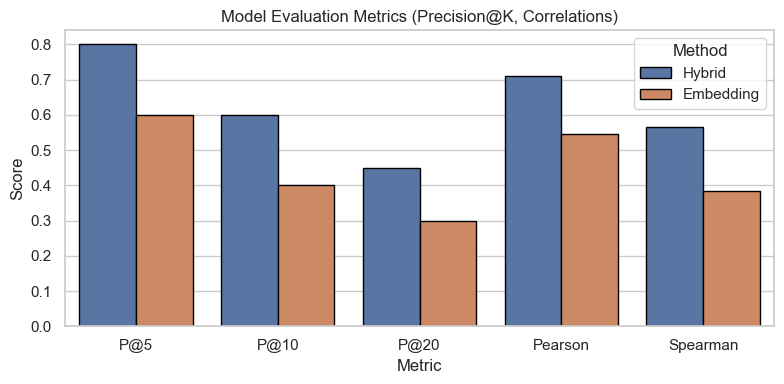

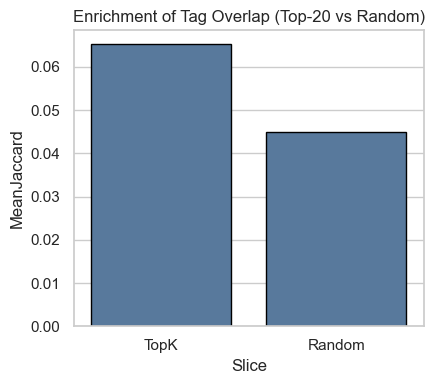

In [5]:


seed_artist = "Travis Scott"
seed_track = "my eyes"

res = recommend_tracks(
    seed_artist,
    seed_track,
    # Use default hybrid weights; 
    ALPHA_EMB=0.55, BETA_TAG=0.25, GAMMA_POP=0.12, DELTA_FRESH=0.08,
    TOP_K=50,  # evaluate on a larger slice if available
)

# 2) Convert to DataFrame and attach a 'tags' column if needed
tracks = pd.DataFrame(res["tracks"])
meta = res["meta"]
seed_tagset = set(meta.get("seed_tags", []))


# 3) Evaluate both hybrid and embedding-only scores where available
metrics_hybrid = evaluate_with_tag_overlap(tracks, "hybrid_score", seed_tagset)
metrics_emb    = evaluate_with_tag_overlap(tracks.assign(hybrid_score=tracks["emb_sim"]), "hybrid_score", seed_tagset)

print_eval_summary("Hybrid score", metrics_hybrid)
print_eval_summary("Embedding-only", metrics_emb)

# 4) Build a small chart for the report
df_plot = pd.DataFrame([
    {"Metric": "P@5",  "Hybrid": metrics_hybrid["P@5"],  "Embedding": metrics_emb["P@5"]},
    {"Metric": "P@10", "Hybrid": metrics_hybrid["P@10"], "Embedding": metrics_emb["P@10"]},
    {"Metric": "P@20", "Hybrid": metrics_hybrid["P@20"], "Embedding": metrics_emb["P@20"]},
    {"Metric": "Pearson",  "Hybrid": metrics_hybrid["corr_pearson"],  "Embedding": metrics_emb["corr_pearson"]},
    {"Metric": "Spearman", "Hybrid": metrics_hybrid["corr_spearman"], "Embedding": metrics_emb["corr_spearman"]},
])

plt.figure(figsize=(8,4))
dfp = df_plot.melt(id_vars="Metric", value_vars=["Hybrid","Embedding"], var_name="Method", value_name="Score")
sns.barplot(data=dfp, x="Metric", y="Score", hue="Method", edgecolor="black")
plt.title("Model Evaluation Metrics (Precision@K, Correlations)")
plt.tight_layout()
plt.savefig("fig_model_eval_metrics.png", dpi=300, bbox_inches="tight")
plt.show()

# 5) Enrichment chart (top-K vs random)
topk = max([int(k.split('@')[-1]) for k in df_plot["Metric"] if "@"
            in k] or [20])
enrich = pd.DataFrame({
    "Slice": ["TopK", "Random"],
    "MeanJaccard": [
        metrics_hybrid.get(f"mean_jacc_top{min(topk, len(tracks))}", np.nan),
        metrics_hybrid.get(f"mean_jacc_rand{min(topk, len(tracks))}", np.nan),
    ],
})
plt.figure(figsize=(4.5,4))
sns.barplot(data=enrich, x="Slice", y="MeanJaccard", color="#4c78a8", edgecolor="black")
plt.title(f"Enrichment of Tag Overlap (Top-{min(topk, len(tracks))} vs Random)")
plt.tight_layout()
plt.savefig("fig_model_eval_enrichment.png", dpi=300, bbox_inches="tight")
plt.show()
